# Support Vector Machine: SGD on Nonlinear Data

In this notebook, we use the Stochastic Gradient Descent (SGD) algorithm for the SVM model to solve a binary classification problem on a **linearly non-separable** dataset.

Unlike the kernel SVM (implemented by Scikit-Learn's SVC class), the SGD algorithm for SVM (implemented by Scikit-Learn's SGDClassifier) is unable to separate nonlinear data. First we need to augment the features by adding polynomial terms. 

We experiment with two cases:

- Case 1: No Feature Augmentation
- Case 2: Feature Augmentation

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

## Function to Draw Decision Boundary 

In [2]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    #plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.RdGy, alpha=0.99)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contour plot for the distance of all points from the hyperplane and the two margins
        plt.contour(x1, x2, y_decision, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='black')
        
        
        #plt.pcolormesh(x1, x2, -y_decision, cmap=plt.cm.RdBu)
        
        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(colorBar==True):
        plt.colorbar()   

## Linearly Non-Separable Dataset

We use Scikit-Learn's "datasets.make_circles" function to generate a synthetic nonlinear dataset that is suitable for investigating classification (as well as clustering) models. It creates a large circle containing a smaller circle in 2d.

The following two parameters are used by the make_circles function:

factor : Scale factor between inner and outer circle. Range 0 ~ 1.

noise : Standard deviation of Gaussian noise added to the data.

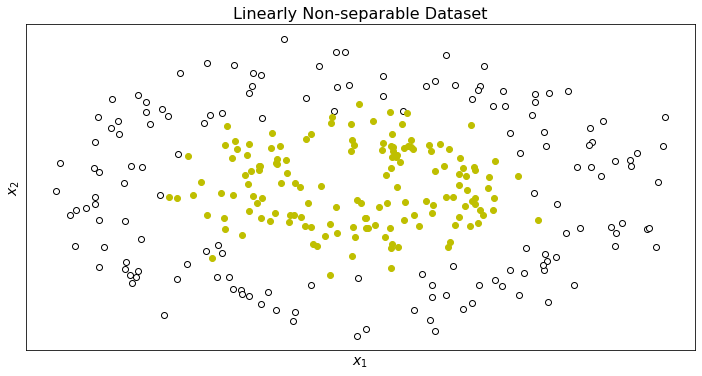

In [3]:
X, y = make_circles(300, factor=0.4, noise=0.15)
label = y

plt.figure(figsize=(12, 6))

plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "wo", markeredgecolor="k")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")

plt.title("Linearly Non-separable Dataset", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.xticks(())
plt.yticks(())
plt.show()

## Create Train & Test Dataset

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## SVM using SGD: No Feature Augmentation

In [5]:
%%time

warnings.filterwarnings('ignore')

svm_sgd_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_sgd", SGDClassifier(loss='hinge')),
    ])


param_grid = {'svm_sgd__alpha': [0.01, 0.001],
              'svm_sgd__penalty' : ["l2", "l1"],
              'svm_sgd__learning_rate': ["constant", "optimal", "invscaling", "adaptive"], 
              'svm_sgd__max_iter':[500, 1000, 3000],
              'svm_sgd__eta0': [0.1, 0.01, 0.001],
              'svm_sgd__tol': [1e-3, 1e-5, 1e-8]}


svm_clf = GridSearchCV(svm_sgd_pipeline, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
svm_clf.fit(X_train, y_train)

params_optimal = svm_clf.best_params_

print("Best Score (F1 micro): %f" % svm_clf.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s


Best Score (F1 micro): 0.735584
Optimal Hyperparameter Values:  {'svm_sgd__alpha': 0.01, 'svm_sgd__eta0': 0.1, 'svm_sgd__learning_rate': 'constant', 'svm_sgd__max_iter': 500, 'svm_sgd__penalty': 'l2', 'svm_sgd__tol': 0.001}


CPU times: user 1.59 s, sys: 115 ms, total: 1.71 s
Wall time: 2.98 s


[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:    2.9s finished


## No Feature Augmentation: Evaluation

In [6]:
y_train_predicted_svm = svm_clf.predict(X_train)

accuracy_score_train_svm = np.mean(y_train_predicted_svm == y_train)
print("\nTrain Accuracy: ", accuracy_score_train_svm)

y_test_predicted_svm = svm_clf.predict(X_test)

accuracy_score_test_svm = np.mean(y_test_predicted_svm == y_test)
print("Test Accuracy: ", accuracy_score_test_svm)


Train Accuracy:  0.4875
Test Accuracy:  0.5333333333333333


## Polynomial SVM using SGD: Feature Augmentation

In [7]:
%%time

warnings.filterwarnings('ignore')

# Create a Pipeline object
svm_sgd_polynomial_pipeline = Pipeline([
        # Bias should be excluded because by default SGDRegressor adds bias via the "fit_intercept" parameter
        ('poly', PolynomialFeatures(include_bias=False)), 
        ('scaler', StandardScaler()),
        ("svm_sgd", SGDClassifier(loss='hinge')),
    ])

param_grid = {'poly__degree': [1, 2, 3],
              'svm_sgd__alpha': [0.01, 0.001],
              'svm_sgd__penalty' : ["l2", "l1"],
              'svm_sgd__learning_rate': ["constant", "optimal", "invscaling", "adaptive"], 
              'svm_sgd__max_iter':[500, 1000, 3000],
              'svm_sgd__eta0': [0.1, 0.01, 0.001],
              'svm_sgd__tol': [1e-3, 1e-5, 1e-8]}


svm_clf_polynomial = GridSearchCV(svm_sgd_polynomial_pipeline, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
svm_clf_polynomial.fit(X_train, y_train)

params_optimal = svm_clf_polynomial.best_params_

print("Best Score (F1 micro): %f" % svm_clf_polynomial.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2368 tasks      | elapsed:    3.7s


Best Score (F1 micro): 0.979721
Optimal Hyperparameter Values:  {'poly__degree': 2, 'svm_sgd__alpha': 0.01, 'svm_sgd__eta0': 0.1, 'svm_sgd__learning_rate': 'constant', 'svm_sgd__max_iter': 1000, 'svm_sgd__penalty': 'l1', 'svm_sgd__tol': 0.001}


CPU times: user 5.87 s, sys: 89.6 ms, total: 5.96 s
Wall time: 6.52 s


[Parallel(n_jobs=-1)]: Done 3888 out of 3888 | elapsed:    6.5s finished


## Feature Augmentation: Evaluation

In [8]:
y_train_predicted_svm_polynomial = svm_clf_polynomial.predict(X_train)

accuracy_score_train_svm_polynomial = np.mean(y_train_predicted_svm_polynomial == y_train)
print("\nTrain Accuracy: ", accuracy_score_train_svm_polynomial)

y_test_predicted_svm_polynomial = svm_clf_polynomial.predict(X_test)

accuracy_score_test_svm_polynomial = np.mean(y_test_predicted_svm_polynomial == y_test)
print("Test Accuracy: ", accuracy_score_test_svm_polynomial)


Train Accuracy:  0.9791666666666666
Test Accuracy:  0.9666666666666667


## Compare Decision Boundaries: Linear SVM vs Polynomial SVM

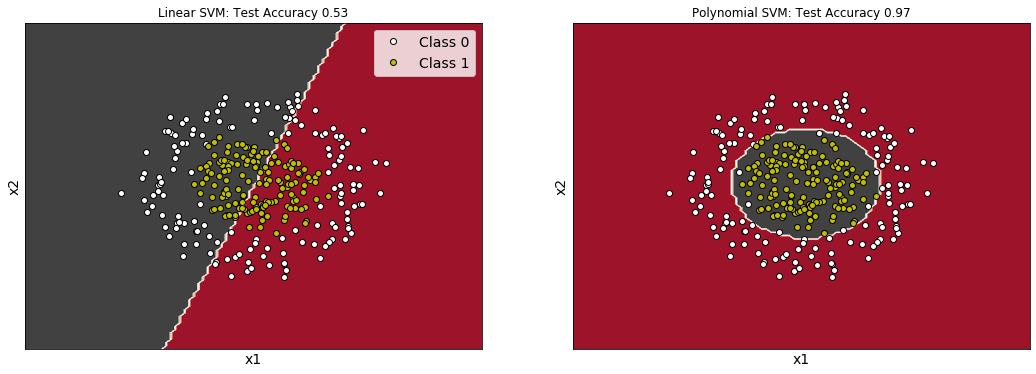

In [9]:
plt.figure(figsize=(18, 6))
plt.subplot(121)

plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "wo", markeredgecolor="k", label="Class 0")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo", markeredgecolor="k", label="Class 1")

decision_boundary_class_colored(svm_clf, X, plotDistanceFromHyperplane=False, colorBar=False)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("Linear SVM: Test Accuracy %.2f" % accuracy_score_test_svm)
plt.xticks(())
plt.yticks(())


plt.subplot(122)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "wo", markeredgecolor="k")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo", markeredgecolor="k")

decision_boundary_class_colored(svm_clf_polynomial, X, plotDistanceFromHyperplane=False, colorBar=False)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.title("Polynomial SVM: Test Accuracy %.2f" % accuracy_score_test_svm_polynomial)
plt.xticks(())
plt.yticks(())
plt.show()